In [1]:
import pandas as pd
import sklearn
import sklearn.ensemble
import xgboost as xgb

from sklearn.model_selection import cross_val_score, StratifiedKFold
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def preprocess(data):


    y = data["SeriousDlqin2yrs"]
    X = data.drop("SeriousDlqin2yrs", axis=1)
    # X = X.fillna(X.mean())
    
    for col in X.columns:
        X[col] = X[col].clip(upper=X[col].quantile(0.999))
        # X[col] = (X[col] - X[col].mean()) / X[col].std()

    X["DebtPayments"] = X["MonthlyIncome"] * X["DebtRatio"]
    return X, y

train_data = pd.read_csv("GiveMeSomeCredit/cs-training.csv",index_col=0)
test_data = pd.read_csv("GiveMeSomeCredit/cs-test.csv",index_col=0)


X_train, y_train = preprocess(train_data)
X_test, y_test = preprocess(test_data)

print(train_data.head())


   SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines  age  \
1                 1                              0.766127   45   
2                 0                              0.957151   40   
3                 0                              0.658180   38   
4                 0                              0.233810   30   
5                 0                              0.907239   49   

   NumberOfTime30-59DaysPastDueNotWorse  DebtRatio  MonthlyIncome  \
1                                     2   0.802982         9120.0   
2                                     0   0.121876         2600.0   
3                                     1   0.085113         3042.0   
4                                     0   0.036050         3300.0   
5                                     1   0.024926        63588.0   

   NumberOfOpenCreditLinesAndLoans  NumberOfTimes90DaysLate  \
1                               13                        0   
2                                4                        0   

Q: What is your preliminary analysis of the given dataset?




Labels:
0.06684% of labels are positive -> severe label imbalance


In [3]:
print(y_train.sum() / y_train.shape[0], "% positive labels")


0.06684 % positive labels




Certain features have outliers, which may be due to poor data quality (e.g. incorrect data entry) and may be detrimental to modeling because of poor representation in the tails.

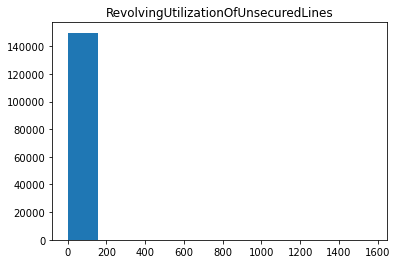

False    150000
Name: RevolvingUtilizationOfUnsecuredLines, dtype: int64


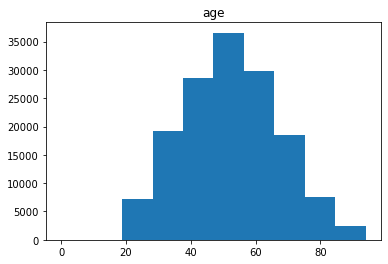

False    150000
Name: age, dtype: int64


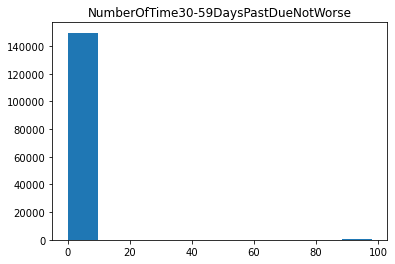

False    150000
Name: NumberOfTime30-59DaysPastDueNotWorse, dtype: int64


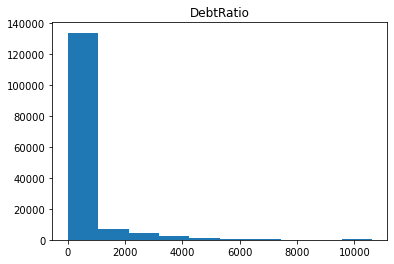

False    150000
Name: DebtRatio, dtype: int64


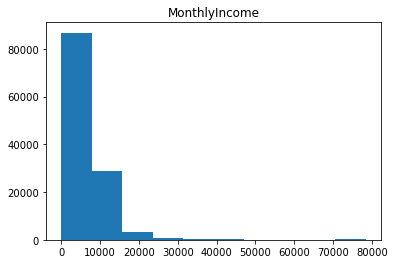

False    120269
True      29731
Name: MonthlyIncome, dtype: int64


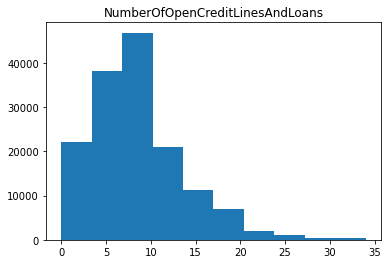

False    150000
Name: NumberOfOpenCreditLinesAndLoans, dtype: int64


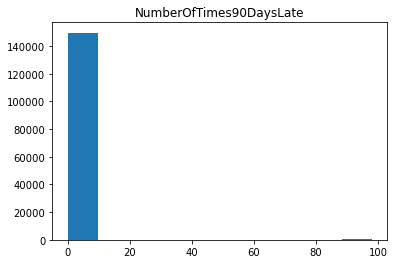

False    150000
Name: NumberOfTimes90DaysLate, dtype: int64


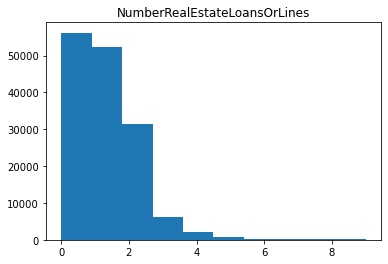

False    150000
Name: NumberRealEstateLoansOrLines, dtype: int64


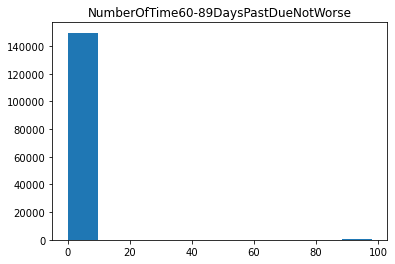

False    150000
Name: NumberOfTime60-89DaysPastDueNotWorse, dtype: int64


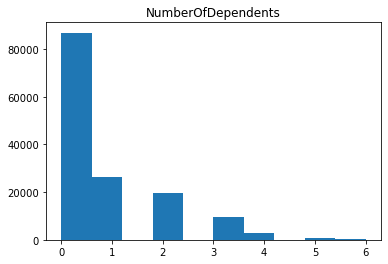

False    146076
True       3924
Name: NumberOfDependents, dtype: int64


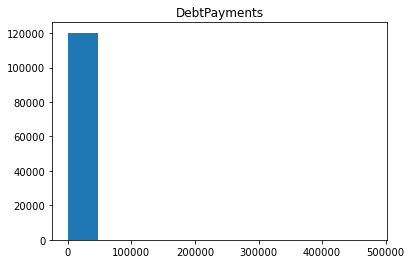

False    120269
True      29731
Name: DebtPayments, dtype: int64


In [4]:
for feat in X_train.columns:
    print("=================")
    plt.title(feat)
    plt.hist(X_train[feat])
    plt.show()
    print(pd.isna(X_train[feat]).value_counts())
    

Notice that the number of times past the due is heavily correlated between each other, which makes sense. The same clients will struggle to make payments, but the number of days will vary, with some stochasticity. It is however surprising to see that the number of times payments are late is not more correlated with the label. This could suggest that clients make an additional effort to make payments as they approach the default line.

Regarding feature missingness, the only 2 features with missing values are 'Monthly Income' and 'Number of Dependants'. In general, feature missingness can be a risk of bias (e.g. selection bias). I would potentially investigate more how the data was acquired and why these 2 features have missing values.
XGBoost can handle missing entries.

<AxesSubplot:>

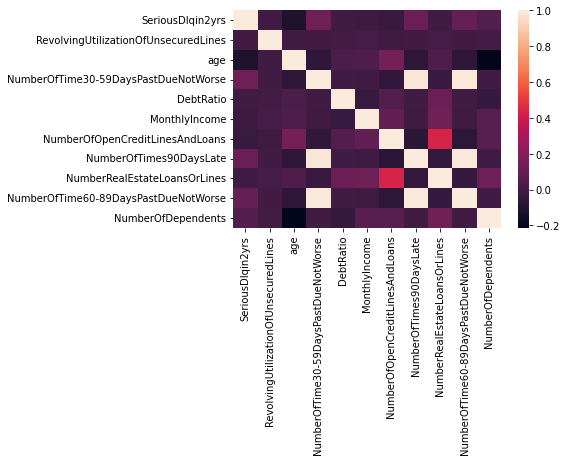

In [5]:
sns.heatmap(train_data.corr())


Q: - Tell us how you validate your model and why you chose such evaluation technique(s).

I chose a stratified 5-fold cross-validation procedure because it allows the entire training set to have a turn at being the held-out validation set. This method therefore reduces overfitting on the validation set since more data is being used to compute performance metrics. I maintained the number of partitions to 5 to reduce runtime and used a stratified method to reduce the variance of label proportions in the partitions, resulting in a better estimate of performance generalization.


Q: - What is AUC? Why do you think AUC was used as the evaluation metric for this challenge? What other metrics do you think would also be suitable for this competition?

AUC, or more precisely AUROC is a metric which evaluates the separability between 2 predicted classes. Depending on the decision threshold used on the model’s prediction probabilities, we obtain a different (true positive rate (TPR) and false-positive rate (FPR)) pair which we may plot onto a Receiving Operating Characteristic (ROC) curve. The AUROC is simply the area under this curve and intuitively represents the probability of correctly classifying a pair of random individuals from each class.
Other classification metrics suitable for this task are AUPRC, F1 score, other metrics derived from the confusion matrix.
In this case, accuracy is not a suitable metric due to the severe class imbalance, which would provide a high score, even with random guessing. Moreover, the importance of correctly classifying each class is not equal.
We could argue that misclassifying a defaulting client is more harmful than the benefit of correctly classifying a client who will pay their loans, as the value lost in a defaulted client may represent the gained interest of multiple others. We would therefore monitor recall, the proportion of defaulting clients the classifier detects and precision, the proportion of flagged clients, who have truly defaulted. By plotting the Precision Recall Curve, and computing the area underneath (AUPRC), we summarize the trade-off of the latter 2 metrics which is a valuable insight in problems with higher importance placed on the positive class.



In [6]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV
# model = sklearn.ensemble.GradientBoostingClassifier(random_state=42)



use_best_hyperparameters = True
if use_best_hyperparameters:
    # found from a random hyperparameter search of 100 runs
    model = xgb.XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.4, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.05, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=8, max_leaves=0, min_child_weight=7,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0)
else:
    params = {
        "learning_rate" : [0.05,0.10,0.15,0.20,0.25,0.30],
        "max_depth" : [ 3, 4, 5, 6, 8, 10, 12, 15],
        "min_child_weight" : [ 1, 3, 5, 7 ],
        "gamma": [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
        "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
    }

    model = RandomizedSearchCV(xgb.XGBClassifier(), \
        param_distributions=params,
        n_iter=100, 
        scoring='roc_auc', 
        cv=StratifiedKFold(n_splits=5, \
            shuffle = True, 
            random_state = 0), 
        verbose=3,
        n_jobs=-1, 
        random_state=0)





# cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring="roc_auc", )






In [7]:

model.fit(X_train, y_train)
test_pred = model.predict_proba(X_test)


submission_dict = {
    "Id": np.arange(1, len(test_pred) + 1),
    "Probability": test_pred[:, 1]
}
submission_df = pd.DataFrame(submission_dict)

submission_df.to_csv("submission.csv", index=False)

In [ ]:
model.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.4, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.05, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=8, max_leaves=0, min_child_weight=7, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

Q: - Short explanation of what you tried. What worked and what did not work (ie. you might have tried different features/models before the final one).

Regarding features, I tried clipping at the 99 quantile (and up), standardizing, imputing missing values with the column mean and adding a new column "DebtPayment" which is mathematically the product of "DebtRatio" and "MonthlyIncome". None of these lead to an improvement of the test metric.

For models, I tried a random forest, a shallow neural network and XGBoost and performed a random search over hyperparameters. The XGBoost model outperformed the other 2.

In [ ]:
best_model = xgb.XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.4, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.05, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=8, max_leaves=0, min_child_weight=7,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0)

In [ ]:
import graphviz

fig, ax = plt.subplots(figsize=(30, 30))
xgb.plot_tree(model, num_trees=4, ax=ax)
plt.show()


In [12]:
import shap
pred = model.predict(X_test, output_margin=True)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.




Q: - What insight(s) do you have from your model(s)?

Using the trained model to compute SHAP values, we can unsurprisingly observe that the number of times the client is late is strongly predictive of the chance of default. In particular, the frequency the user is 90 days late is most predictive of the risk of default and this feature seems to never be only mildly indicative of defaulting risk. 

A Surprising observation is that age is negatively predictive of defaulting risk, perhaps because younger borrowers have more resilience during times of financial distress.

Another interesting observation is that the number of open credit lines and loans seems to be positively predicive of default when it is low but negatively predictive when high. This could be explained by the fact that clents who default tend to have poor credit histories and financial states and therefore struggle to obtain more loans, while clients with assets and good financial management skills utilize multiple loan opportunities well.

Finally, another non-linear trend is with the number of real estate loans feature. It is interesting to note that clients who have a low number of such loans have a lower chance of defaulting than clients without. But, those with a high number of such loans default more.

Future work:
- Visualize the PRC curve to see if there is a threshold for which precision or recall plateaus.\
- Make the XGBoost visualizer work to interpret the model decisions



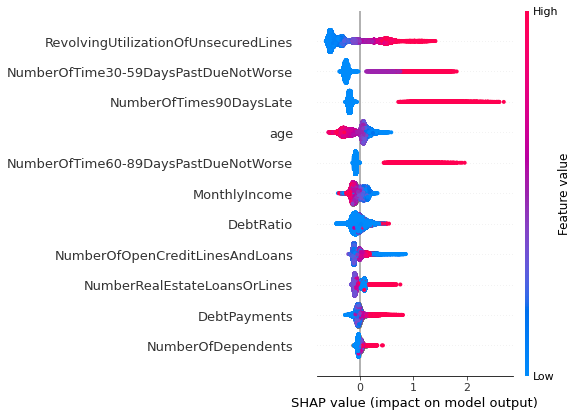

In [13]:
shap.summary_plot(shap_values, X_test)


Q: - Can you get into the top 100 of the private leaderboard or even higher? 

Yes! See myrank.jpg